[Category(index=1, score=0.9881962537765503, display_name='Left', category_name='Left')]


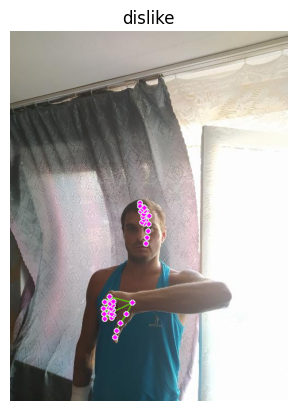

Writen 1 samples of dislike


In [190]:
import cv2
import csv
import json
import os
import random
import matplotlib.pyplot as plt
import numpy as np

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

LANDMARKER_MODEL_PATH = 'models/hand_landmarker.task'
CSV_DATASET_PATH = 'datasets/HandLandmarks.csv'
IMAGE_DATASET_DIR = "E:/MyDatasets/hagrid_dataset_512"
ANNOTATIONS_DIR = "E:/MyDatasets/hagrid_dataset_annotations/train"
LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted']

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode


def rotate_around_point0_3d(landmark_array):
    landmarks_xyz = landmark_array[1:].reshape(-1, 3)
    point0 = landmarks_xyz[0]
    point5 = landmarks_xyz[5]

    # Vector from point 0 to point 5
    vector_0_to_5 = point5 - point0

    # Rotation axis (cross product of vector_0_to_5 and z-axis)
    rotation_axis = np.cross(vector_0_to_5, [0, 0, 1])
    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)  # Normalize the rotation axis

    # Angle between vector_0_to_5 and z-axis
    angle = np.arccos(np.dot(vector_0_to_5, [0, 0, 1]) / (np.linalg.norm(vector_0_to_5) * np.linalg.norm([0, 0, 1])))

    # Rodrigues' rotation formula components
    K = np.array([[0, -rotation_axis[2], rotation_axis[1]],
                  [rotation_axis[2], 0, -rotation_axis[0]],
                  [-rotation_axis[1], rotation_axis[0], 0]])
    rotation_matrix = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * np.dot(K, K)

    # Translate points so point 0 is at the origin, rotate, and then translate back
    translated_points = landmarks_xyz - point0
    rotated_translated_points = np.dot(translated_points, rotation_matrix.T)
    rotated_points = rotated_translated_points + point0

    # Combine rotated points back into the landmark array format
    rotated_landmarks_array = np.append(landmark_array[0], rotated_points.flatten())
    return rotated_landmarks_array








class HandDataPrepare():
    def __init__(self):
        self.NUM_SAMPLES = 1
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_hands = mp.solutions.hands

    #############
    def draw_landmarks_on_image(self, annotated_image, hand_landmarks):
            self.mp_drawing.draw_landmarks(annotated_image, hand_landmarks,
                                        self.mp_hands.HAND_CONNECTIONS,
                                        landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                                            color=(255, 0, 255), thickness=4, circle_radius=2),
                                        connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                                            color=(20, 180, 90), thickness=2, circle_radius=2)
            )
            return annotated_image
    ##############
    

    # Pop out a random key
    def pop_random_key(self, keys_list):
        if not keys_list:
            print("No more keys to select.")
            return None
        random_idx = random.randint(0, len(keys_list) - 1)
        return keys_list.pop(random_idx)

    
    # Check if the point (x, y) is within the bounding box.
    def is_point_in_bbox(self, x, y, bbox, margin=0.01):
        if bbox == None:
            return True
        tl_x, tl_y, width, height = bbox
        ext_tl_x = tl_x - margin
        ext_tl_y = tl_y - margin
        ext_br_x = tl_x + width + margin
        ext_br_y = tl_y + height + margin
        return ext_tl_x <= x <= ext_br_x and ext_tl_y <= y <= ext_br_y
    

    # Preprocess the hand landmark (modify) ######################
    def pre_process_landmark(self, hand_landmarks, handedness, gesture_bboxes=None):
        landmark_list = []
        # Convert to relative coordinates
        for idx, landmark in enumerate(hand_landmarks):
            if self.is_point_in_bbox(landmark.x, landmark.y, gesture_bboxes):
                if idx == 0:
                    base_x, base_y, base_z = landmark.x, landmark.y, landmark.z
                landmark_list.extend([landmark.x - base_x, landmark.y - base_y, landmark.z - base_z])
            else:
                break
        # Convert to numpy array and add handedness
        landmark_array = np.array([handedness[0].index] + landmark_list).astype(np.float32)         # Right is 0, Left is 1
        return landmark_array
    
    # Preprocess the hand landmark (no modify)
    def pre_process_landmark_original(self, hand_landmarks, handedness, gesture_bboxes=None):
        landmark_list = []
        # Convert to relative coordinates
        for idx, landmark in enumerate(hand_landmarks):
            if self.is_point_in_bbox(landmark.x, landmark.y, gesture_bboxes):
                landmark_list.extend([landmark.x, landmark.y])
            else:
                break
        # Convert to numpy array and add handedness
        landmark_array = np.array([handedness[0].index] + landmark_list).astype(np.float32)         # Right is 0, Left is 1
        return landmark_array
    

    ############################################
    def rotate_around_point0(self, landmark_array):
        landmarks_xy = landmark_array[1:].reshape(-1,3)[:,:2]
        point5 = landmarks_xy[5]
        dx, dy = point5
        angle = np.arctan2(dy, dx) + np.pi / 2
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        rotation_landmarks_xy = landmarks_xy.dot(rotation_matrix)

        rotated_landmarks = np.append(landmark_array[0], np.hstack((rotation_landmarks_xy, landmark_array[1:].reshape(-1,3)[:,2:])).flatten())
        
        print(rotated_landmarks)
        return rotated_landmarks
    ############################################


    def main(self):
        # STEP 1: Create an HandLandmarker object.
        options = HandLandmarkerOptions(
            base_options=BaseOptions(model_asset_path=LANDMARKER_MODEL_PATH),
            running_mode=VisionRunningMode.IMAGE)
        
        with HandLandmarker.create_from_options(options) as landmarker:
            with open(CSV_DATASET_PATH, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)

                # STEP 2: Load the input image.
                # for label in LABELS:
                for label in [random.choice(LABELS)]:       ###############
                # for label in ['fist']:
                    with open(os.path.join(ANNOTATIONS_DIR, f"{label}.json"), 'r') as file:
                        annotations = json.load(file)
                    annotations_keys = list(annotations.keys())
                    
                    samples_cnt = 0
                    while samples_cnt < self.NUM_SAMPLES:
                        # print(len(annotations_keys))        ####################
                        image_name = self.pop_random_key(annotations_keys)
                        image_path = os.path.join(IMAGE_DATASET_DIR, label, f'{image_name}.jpg')
                        mp_image = mp.Image.create_from_file(image_path)

                        # STEP 3: Detect hand landmarks from the input image.
                        hand_landmarker_result = landmarker.detect(mp_image)
                        # print(hand_landmarker_result)           ################


                        if hand_landmarker_result is not None:
                            # STEP 4: Write hand landmark into csv
                            annotations_labels = annotations[image_name]['labels']
                            annotations_bboxes = annotations[image_name]['bboxes']
                            gesture_bboxes = annotations_bboxes[annotations_labels.index(label)]

                            for hand_landmarks, handedness in zip(hand_landmarker_result.hand_landmarks,
                                                                  hand_landmarker_result.handedness):
                                # print(hand_landmarks)       ###########
                                print(handedness)       ############
                                landmark_array = self.pre_process_landmark(hand_landmarks, handedness, gesture_bboxes)
                                # print(landmark_array)        ######################
                                row = [LABELS.index(label)] + landmark_array.tolist()
                                # print(row)      #############################


                                
                                
                                # hand_landmarks plot ########################################################
                                hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
                                hand_landmarks_proto.landmark.extend([
                                    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
                                ])
                                hand_landmarks_proto2 = landmark_pb2.NormalizedLandmarkList()
                                hand_landmarks_proto2.landmark.extend([
                                    landmark_pb2.NormalizedLandmark(x=landmark[0]+0.5, y=landmark[1]+0.5, z=landmark[2]) for landmark in rotate_around_point0_3d(landmark_array)[1:].reshape([-1,3])
                                ])
                                annotated_image = self.draw_landmarks_on_image(cv2.imread(image_path), hand_landmarks_proto)
                                annotated_image = self.draw_landmarks_on_image(annotated_image, hand_landmarks_proto2)
                                plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
                                plt.title(label)
                                plt.axis('off')
                                plt.show()
                                # print(annotations[image_name])
                                # print(row) 
                                ################################
                                
                                # if len(row) == 21 * 2 + 2:
                                if True:
                                    csvwriter.writerow(row)
                                    samples_cnt += 1
                    print(f"Writen {samples_cnt} samples of {label}")
                    return landmark_array



if __name__ == "__main__":
    body_module = HandDataPrepare()
    landmark_array = body_module.main()

In [152]:
landmark_array_copy = landmark_array.copy()
landmark_array_copy

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.02267678,
       -0.01100582, -0.00960333,  0.03854395, -0.0301331 , -0.0135596 ,
        0.03808306, -0.0458782 , -0.01791784,  0.02769412, -0.05683857,
       -0.01991074,  0.04596196, -0.04501325,  0.00405025,  0.04092957,
       -0.05876917, -0.00794947,  0.03181742, -0.04971296, -0.01480978,
        0.0281827 , -0.04385135, -0.01717635,  0.03028925, -0.04787129,
        0.00363964,  0.02127011, -0.05890715, -0.00786745,  0.01650347,
       -0.04520202, -0.01064496,  0.02083386, -0.04100028, -0.00931378,
        0.01383531, -0.04796374,  0.00023548,  0.00529118, -0.05778524,
       -0.01129866,  0.00342332, -0.04402676, -0.00902327,  0.00887774,
       -0.03956196, -0.00411943, -0.00178055, -0.04639104, -0.00435259,
       -0.00723161, -0.05403149, -0.00929668, -0.0073096 , -0.04518092,
       -0.00557921, -0.00251429, -0.0409756 , -0.00075218], dtype=float32)

In [72]:
landmarks_xy = landmark_array[1:].reshape(-1,3)[:,:2]
point5 = landmarks_xy[5]
dx, dy = point5
if dy > 0: 
    angle = np.arctan2(dy, dx) - np.pi / 2
else:
    angle = np.arctan2(dy, dx) + np.pi / 2
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
rotation_landmarks_xy = landmarks_xy.dot(rotation_matrix)

landmark_array_rotation = np.append(landmark_array[0], np.hstack((rotation_landmarks_xy, landmark_array[1:].reshape(-1,3)[:,2:])).flatten())

# landmarks_xy, point5, angle, rotation_matrix, rotation_landmarks_xy
landmark_array_rotation

array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.86202970e-02, -2.04314100e-02, -1.45227946e-02, -2.86682276e-02,
       -4.55947796e-02, -2.40030251e-02, -3.22722487e-02, -6.69382525e-02,
       -3.19608226e-02, -3.83924003e-02, -8.41010443e-02, -3.96973640e-02,
        6.40349047e-09, -5.89594089e-02, -1.71562470e-02, -5.55977992e-04,
       -8.47559931e-02, -2.92539746e-02, -3.39109721e-04, -1.01794293e-01,
       -3.83035988e-02,  5.60256452e-04, -1.15741383e-01, -4.42819409e-02,
        1.70936023e-02, -5.24730828e-02, -1.71597712e-02,  2.79332156e-02,
       -7.58927354e-02, -2.75856256e-02,  3.52044088e-02, -9.14180900e-02,
       -3.43509577e-02,  4.12919371e-02, -1.04381369e-01, -3.84697579e-02,
        3.05172862e-02, -4.13147234e-02, -1.88486408e-02,  4.23810736e-02,
       -6.27046158e-02, -2.91677285e-02,  4.91685367e-02, -7.60885534e-02,
       -3.49911414e-02,  5.45293452e-02, -8.74969530e-02, -3.80194336e-02,
        4.12728418e-02, -

In [56]:
dx, dy = 0, -1
angle = np.arctan2(dy, dx) + np.pi / 2
angle

0.0

In [1]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
 
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image2(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

HandLandmarkerResult(handedness=[[Category(index=1, score=0.9919922351837158, display_name='Left', category_name='Left')]], hand_landmarks=[[NormalizedLandmark(x=0.5314213037490845, y=0.33333736658096313, z=-7.586061201436678e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48625147342681885, y=0.32424044609069824, z=-0.0022827014327049255, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.46524351835250854, y=0.30565908551216125, z=-0.005809617228806019, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.45003485679626465, y=0.28839361667633057, z=-0.011416574940085411, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.43868204951286316, y=0.2749442458152771, z=-0.017848648130893707, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4867594838142395, y=0.26509276032447815, z=-0.0015210759593173862, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.47812604904174805, y=0.23787644505500793, z=-0.010450790636241436, visibility=0.0, presence=0.0), NormalizedLa

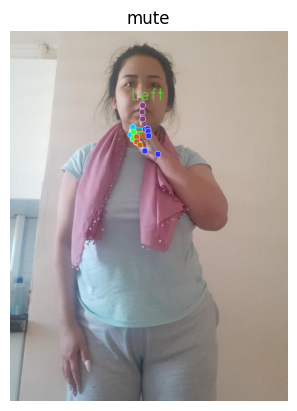

{'bboxes': [[0.16810129, 0.78975455, 0.13236671, 0.19417131], [0.41666614, 0.18111505, 0.1413608, 0.17471628]], 'user_id': '8cae201068904c1663263cc6d51bf2422088a13a17d79e0cfd4616896e73fc3d', 'labels': ['no_gesture', 'mute']}
[4, 0.5314213037490845, 0.33333736658096313, -7.586061201436678e-08, 0.48625147342681885, 0.32424044609069824, -0.0022827014327049255, 0.46524351835250854, 0.30565908551216125, -0.005809617228806019, 0.45003485679626465, 0.28839361667633057, -0.011416574940085411, 0.43868204951286316, 0.2749442458152771, -0.017848648130893707, 0.4867594838142395, 0.26509276032447815, -0.0015210759593173862, 0.47812604904174805, 0.23787644505500793, -0.010450790636241436, 0.4759645462036133, 0.21851058304309845, -0.018116449937224388, 0.4771667420864105, 0.20095989108085632, -0.025168685242533684, 0.49453645944595337, 0.2642427384853363, -0.007587821688503027, 0.4427224397659302, 0.26043522357940674, -0.021123521029949188, 0.43450719118118286, 0.27980464696884155, -0.023752365261316

In [17]:
# STEP 1: Create an HandLandmarker object.
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=LANDMARKER_MODEL_PATH),
    running_mode=VisionRunningMode.IMAGE)

with HandLandmarker.create_from_options(options) as landmarker:
    label = random.choice(LABELS)       ######
    with open(os.path.join(ANNOTATIONS_DIR, f"{label}.json"), 'r') as file:
        annotations = json.load(file)
    
    image_name = random.choice(list(annotations.keys()))
    image_path = os.path.join(IMAGE_DATASET_DIR, label, f'{image_name}.jpg')
    mp_image = mp.Image.create_from_file(image_path)

    # STEP 3: Detect hand landmarks from the input image.
    hand_landmarker_result = landmarker.detect(mp_image)
    print(hand_landmarker_result)

    # Process the classification result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), hand_landmarker_result)

    # Display the image
    plt.imshow(annotated_image)
    plt.title(label)
    plt.axis('off')  # Hide the axes
    plt.show()

    print(annotations[image_name])

    # STEP 4: Write hand landmark into csv
    annotations_labels = annotations[image_name]['labels']
    annotations_bboxes = annotations[image_name]['bboxes']
    gesture_bboxes = annotations_bboxes[annotations_labels.index(label)]

    label_dict = {label: i for i, label in enumerate(LABELS)}
    for hand_landmarks in hand_landmarker_result.hand_landmarks:
        row = [label_dict[label]]                ############ 
        for landmark in hand_landmarks:
            if body_module.is_point_in_bbox(landmark.x, landmark.y, gesture_bboxes):
                row.extend([landmark.x, landmark.y, landmark.z])
            
        print(row)